In [1]:
import pandas as pd
import cv2

import os

import numpy as np


In [2]:
os.chdir('../data_augmentation')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling/data_augmentation


In [3]:
from data_augmentation import DataAugmentation
dataAugm = DataAugmentation(data_dir="data",
                            #target_dir="/home/dmitrii/GitHub/AnomaliesRecycling/data/copy_and_paste/results",
                            zero_lid_dir='data_augmentation/data/zero_lid.csv',
                            one_lid_dir='data_augmentation/data/one_lid.csv')


Generating and saving masks for image 0 of 1072
Generating and saving masks for image 100 of 1072
Generating and saving masks for image 200 of 1072
Generating and saving masks for image 300 of 1072
Generating and saving masks for image 400 of 1072
Generating and saving masks for image 500 of 1072
Generating and saving masks for image 600 of 1072
Generating and saving masks for image 700 of 1072
Generating and saving masks for image 800 of 1072
Generating and saving masks for image 900 of 1072
Generating and saving masks for image 1000 of 1072


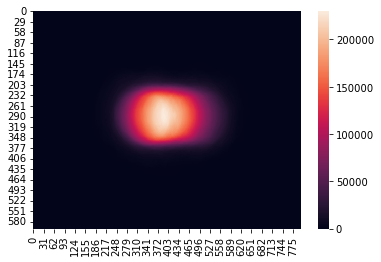

In [4]:
dataAugm.extract_masks()
summed_mask = dataAugm.get_sum_binary_mask()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

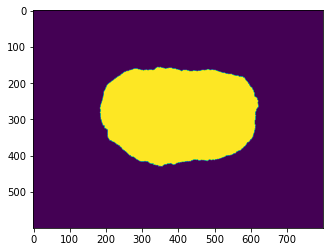

In [5]:
dataAugm.get_percentile_sum_binary_mask(summed_mask=summed_mask, percentile=80)

In [6]:
from PIL import Image
import cv2
from IPython.display import display
def show_cv(img_in):
    img = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    display(Image.fromarray(img))

In [7]:
show_cv(dataAugm.copy_and_paste(4))

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'


In [8]:
dataAugm.generate({0: 361,
                   1: 1509, 
                   2: 570,
                   3: 170,
                   4: 40,
                   5: 10,
                   })

In [9]:
df_synthesized = pd.read_csv('../data/labels/synthesized/synthesized.csv')
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[~df_train['name'].str.contains('synthesized')]
df_train = pd.concat([df_train, df_synthesized], ignore_index=True).fillna(0)
df_train = df_train.convert_dtypes()
df_train['synthesized'] = df_train['synthesized'].astype(int)
df_train.to_csv('../data/train.csv', index=False)
df_train

,name,count,edge,different colors,one color,transparent,inside,overlapping,dark color,open lid,synthesized
0,cluttered/Anlerndaten (568).jpg,2,0,0,1,0,0,0,0,0,0
1,presorted/trial (1544).jpg,2,0,1,0,0,0,1,0,0,0
2,presorted/trial (1673).jpg,1,0,0,0,0,0,0,0,0,0
3,cluttered/Anlerndaten (454).jpg,1,0,0,0,1,0,0,0,0,0
4,cluttered/Anlerndaten (184).jpg,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5315,synthesized/label_5_img_5.jpg,5,0,0,0,0,0,1,0,0,1
5316,synthesized/label_5_img_6.jpg,5,0,0,0,0,0,1,0,0,1
5317,synthesized/label_5_img_7.jpg,5,0,0,0,0,0,1,0,0,1
5318,synthesized/label_5_img_8.jpg,5,0,0,0,0,0,0,0,0,1


In [10]:
df_train.tail(2)

,name,count,edge,different colors,one color,transparent,inside,overlapping,dark color,open lid,synthesized
5318,synthesized/label_5_img_8.jpg,5,0,0,0,0,0,0,0,0,1
5319,synthesized/label_5_img_9.jpg,5,0,0,0,1,0,1,0,0,1


In [9]:
dataAugm.empty_trays.iloc[len(dataAugm.empty_trays)]['name']

IndexError: single positional indexer is out-of-bounds

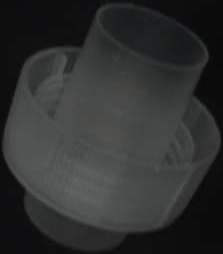

(254, 223, 3)


In [10]:
#generate BB
img = dataAugm.masks[0]
x,y,w,h = cv2.boundingRect(img.cnt)
image = img.image
#cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,255), 2)
image = image[y:y+h, x:x+w]
show_cv(image)
print(image.shape)